# Model Explainability Analysis
This notebook generates visualizations and analysis for our model's explainability report.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

/Users/jusepulveda/Documents/ds_tech_task/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
df = pd.read_csv('../data/Food_Delivery_Times.csv')

# Create feature matrix X and target variable y
features = ['Distance_km', 'Traffic_Level', 'Weather', 'Vehicle_Type', 
           'Preparation_Time_min', 'Courier_Experience_yrs']
X = df[features].copy()

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=['Traffic_Level', 'Weather', 'Vehicle_Type'])
y = df['Delivery_Time_min']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [3]:
# Create directory for images if it doesn't exist
import os
IMAGES_DIR = '../reports/images'
os.makedirs(IMAGES_DIR, exist_ok=True)

def save_fig(fig, filename):
    """Save figure to images directory with high quality"""
    fig.savefig(os.path.join(IMAGES_DIR, filename), 
                dpi=300, bbox_inches='tight')

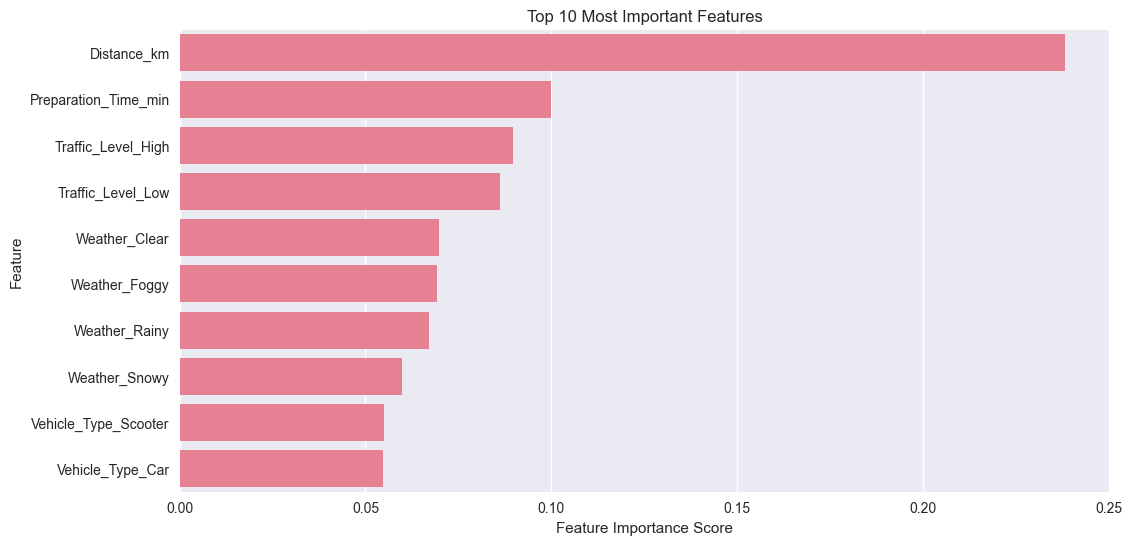

In [4]:
# 1. Feature Importance Plot
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
save_fig(plt.gcf(), 'feature_importance.png')
plt.show()

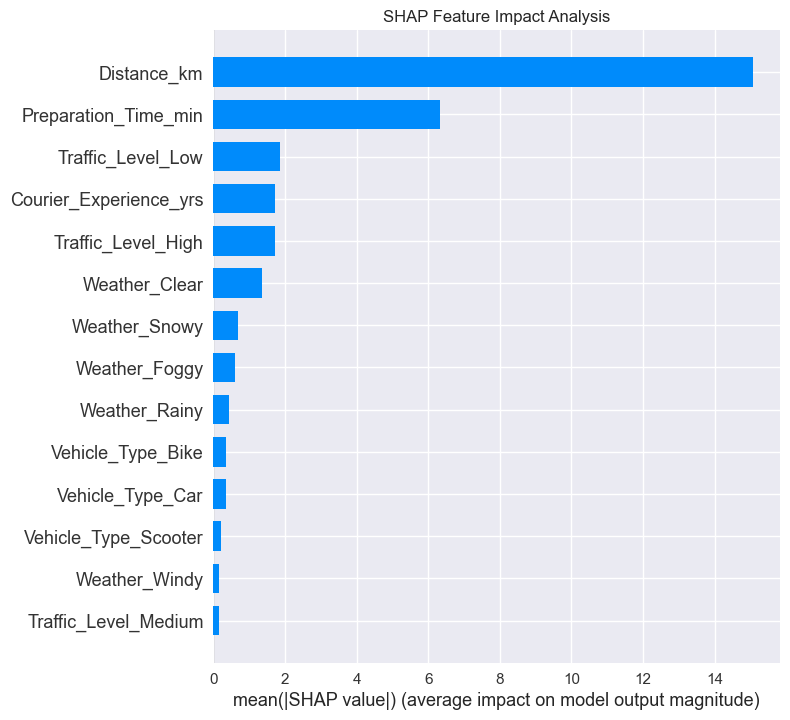

<Figure size 1000x600 with 0 Axes>

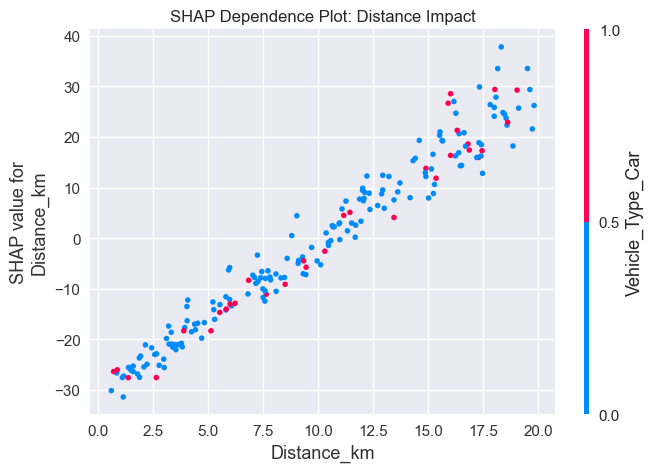

In [5]:
# 2. SHAP Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('SHAP Feature Impact Analysis')
save_fig(plt.gcf(), 'shap_analysis.png')
plt.show()

# Detailed SHAP interaction plot for top features
plt.figure(figsize=(10, 6))
shap.dependence_plot("Distance_km", shap_values, X_test, show=False)
plt.title('SHAP Dependence Plot: Distance Impact')
save_fig(plt.gcf(), 'shap_distance_dependence.png')
plt.show()

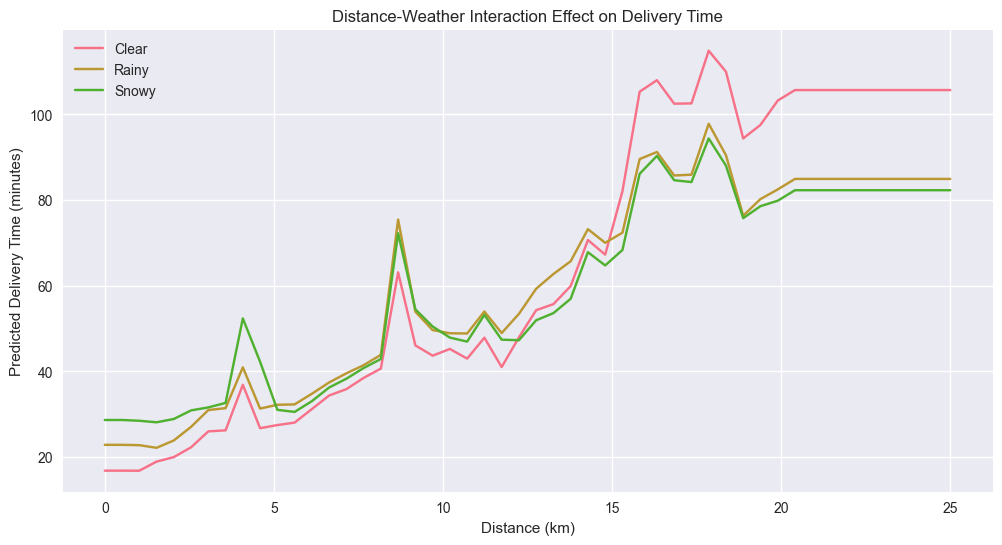

In [6]:
# 3. Interaction Effects Visualization
# Create a matrix of predictions for distance and weather conditions
distances = np.linspace(0, 25, 50)
weather_conditions = ['Clear', 'Rainy', 'Snowy']
predictions = []

for weather in weather_conditions:
    temp_predictions = []
    for dist in distances:
        # Create a sample row with this distance and weather
        sample = X_train.iloc[0:1].copy()
        sample['Distance_km'] = dist
        # Reset all weather columns to 0
        weather_cols = [col for col in sample.columns if col.startswith('Weather_')]
        sample[weather_cols] = 0
        # Set the current weather condition
        sample[f'Weather_{weather}'] = 1
        
        pred = model.predict(sample)[0]
        temp_predictions.append(pred)
    predictions.append(temp_predictions)

plt.figure(figsize=(12, 6))
for i, weather in enumerate(weather_conditions):
    plt.plot(distances, predictions[i], label=weather)

plt.xlabel('Distance (km)')
plt.ylabel('Predicted Delivery Time (minutes)')
plt.title('Distance-Weather Interaction Effect on Delivery Time')
plt.legend()
save_fig(plt.gcf(), 'weather_distance_interaction.png')
plt.show()